In [ ]:
import albumentations as A                              # for augmentation transform

import numpy as np                                      # sci kit specials ;D
import matplotlib.pyplot as plt                         # plots
from PIL import Image                                   # for opening images as numpy arrays or torch tensors

from datetime import datetime                           # for model timestamp

import torch

from torch.utils.data import Dataset                    # preset class for creating a dataset
from torch.utils.data import random_split               # for splitting datasets into training, test, validation
from torch.utils.data import DataLoader                 # self-explanitory
import segmentation_models_pytorch as smp               # preset model

from tqdm import tqdm                                   # for the progress bar
import os                                               # for accessing files and setting proper paths to   them

from torch.utils.tensorboard import SummaryWriter       # tensorboard srv

/home/krzeslaav/bachlor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-28 13:52:58.803136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import collections
from copy import deepcopy


In [3]:
from skimage.morphology import remove_small_objects, remove_small_holes, closing,skeletonize
from skimage.measure import find_contours

from skimage import data, morphology, measure
from skimage.util import invert

from scipy import ndimage

import os
from PIL import Image

In [5]:
DEBUG = True

if DEBUG==True:

  MASK_TRAIN_PATH = "../assets/datasets/DeepCrack/train_lab"
  IMG_TRAIN_PATH = "../assets/datasets/DeepCrack/train_img"
  MASK_TEST_PATH = "../assets/datasets/DeepCrack/test_lab"
  IMG_TEST_PATH = "../assets/datasets/DeepCrack/test_img"
  DEVICE = "cpu"
  WORKERS = 4

else:
  MASK_TRAIN_PATH = "/content/DeepCrack/train_lab"
  IMG_TRAIN_PATH = "/content/DeepCrack/train_img"
  MASK_TEST_PATH = "/content/DeepCrack/test_lab"
  IMG_TEST_PATH = "/content/DeepCrack/test_img"

  DEVICE="cuda"
  WORKERS = 4

BATCH_SIZE = 32
PIN_MEMORY = True
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 1

EARLY_STOPPING_PATIENCE = 15

SCHEDULER_PATIENCE = 5
SCHEDULER_FACTOR = 0.5

In [6]:
def model_load(path_checkpoint, device="cpu"):
  if device == "cuda":
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  checkpoint = torch.load(path_checkpoint, map_location=device, weights_only=False)

  model = smp.Unet(
      encoder_name="resnet34",
      encoder_weights="imagenet",
      in_channels=3,
      classes=1,
      activation=None,
  )

  model = model.to(device)
  model.load_state_dict(checkpoint['model_state_dict'])
    
    # Ustaw w trybie ewaluacji
  model.eval()
    
    # Wyświetl informacje
  print(f"Model loaded from: {path_checkpoint}")
  print(f"   \t             Device: {device}")
  print(f"   \t     Trained epochs: {checkpoint['epoch'] + 1}")
  print(f"   \tBest validation IoU: {checkpoint['best_val_iou']:.4f}")
    
  return model, checkpoint



In [7]:
transform_val = A.Compose(
  [A.Resize(height=512, width=512)]
)

In [8]:
def fetch_data(path) -> list:
  """Return files as their paths+filename in an array"""

  assert (os.path.exists(path) == True),  "Failure during data fetching"

  result = []
  for file in tqdm(os.listdir(path), desc=f"Loading files from {path} ",unit="File", leave=True):
    fpath = os.path.join(path,file)
    result.append(fpath)

  print(f"{path} - len({len(result)})")
  return result


class DeepCrackDataset(Dataset):
  def __init__(self, img_dir, mask_dir, transform=None):

    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.transform = transform

    # sort values so the file names corespoding to each other are loaded in order
    self.images = sorted([os.path.join(img_dir, file) for file in os.listdir(img_dir)] )
    self.masks = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir)])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    np_image = np.array(Image.open(self.images[index]))
    np_mask = np.array(Image.open(self.masks[index]))


    if len(np_mask.shape) == 3:
      np_mask = np_mask[:,:,0]

    np_mask = (np_mask > 127).astype(np.uint8)

    if self.transform: # if using transforms
      t = self.transform(image=np_image, mask=np_mask)
      np_image = t["image"]
      np_mask = t["mask"]

    # conversion from numpy array convention to tensor via permute,
    #     then normalizing to [0,1] range, same for mask, only using binary data
    tensor_image = torch.from_numpy(np_image).permute(2, 0, 1).float() / 255.0
    tensor_mask = torch.from_numpy(np_mask).unsqueeze(0).float()

    return tensor_image,tensor_mask


def get_dataset(img_path = IMG_TRAIN_PATH, mask_path = MASK_TRAIN_PATH, transform_train = None ):

  dataset = DeepCrackDataset(img_path, mask_path, transform=transform_train)
  return dataset

def split_dataset(dataset: DeepCrackDataset, test_factor:float, val_factor:float )->list:
  """Split exising dataset given percentages as [0,1] floats, return list of  """
  return random_split(dataset, [test_factor, val_factor])

In [51]:
device = DEVICE
model, checkpoint = model_load("../f_loss_comparison/model_bce.pth", device)

Model loaded from: ../f_loss_comparison/model_bce.pth
   	             Device: cpu
   	     Trained epochs: 13
   	Best validation IoU: 0.6428


In [10]:
# get the samples

dataset = get_dataset(IMG_TEST_PATH, MASK_TEST_PATH, transform_train=transform_val)
dataset2 = get_dataset(IMG_TRAIN_PATH, MASK_TRAIN_PATH, transform_train=None)

data_loader = DataLoader( dataset, batch_size=BATCH_SIZE , shuffle=False, num_workers=WORKERS    , pin_memory=PIN_MEMORY)

print(len(dataset2))


300


In [11]:
def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()

    all_predictions = []
    all_ground_truths = []

    print("Running evaluation...")

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Processing batches"):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            predictions = torch.sigmoid(outputs)

            # Do CPU
            all_predictions.append(predictions.cpu().numpy())
            all_ground_truths.append(masks.cpu().numpy())

    # Concatenate
    predictions = np.concatenate(all_predictions, axis=0)[:, 0]  # [N, H, W]
    ground_truths = np.concatenate(all_ground_truths, axis=0)[:, 0]  # [N, H, W]

    # Binaryzacja
    pred_binary = (predictions > threshold).astype(np.float32)
    gt_binary = (ground_truths > 0.5).astype(np.float32)

    # ========================================
    # OBLICZ METRYKI
    # ========================================
    ious = []
    precisions = []
    recalls = []
    f1_scores = []
    accuracies = []

    for pred, gt in zip(pred_binary, gt_binary):
        # Confusion matrix
        tp = (pred * gt).sum()
        fp = (pred * (1 - gt)).sum()
        fn = ((1 - pred) * gt).sum()
        tn = ((1 - pred) * (1 - gt)).sum()

        # IoU (Intersection over Union)
        iou = tp / (tp + fp + fn + 1e-6)
        ious.append(iou)

        # Precision (jakość detekcji)
        precision = tp / (tp + fp + 1e-6)
        precisions.append(precision)

        # Recall (czułość)
        recall = tp / (tp + fn + 1e-6)
        recalls.append(recall)

        # F1 Score (harmonic mean)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        f1_scores.append(f1)

        # Accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)
        accuracies.append(accuracy)

    metrics = {
        'iou_mean': np.mean(ious),
        'iou_std': np.std(ious),
        'iou_median': np.median(ious),
        'precision_mean': np.mean(precisions),
        'precision_std': np.std(precisions),
        'recall_mean': np.mean(recalls),
        'recall_std': np.std(recalls),
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'accuracy_mean': np.mean(accuracies),
        'ious': ious,
        'precisions': precisions,
        'recalls': recalls,
        'f1_scores': f1_scores,
    }

    return metrics, predictions, ground_truths

In [28]:
metrics, predictions, ground_truths = evaluate_model(model, data_loader, device)

Running evaluation...


Processing batches:   0%|          | 0/8 [00:18<?, ?it/s]


KeyboardInterrupt: 

In [11]:
for k, v in metrics.items():
    if isinstance(v, list):
        print(f"{k} -> {[f'{i:.4f}' for i in v]}")
    else:
        print(f"{k} -> {v:.4f}")

iou_mean -> 0.6445
iou_std -> 0.1910
iou_median -> 0.6915
precision_mean -> 0.8496
precision_std -> 0.1481
recall_mean -> 0.7472
recall_std -> 0.2163
f1_mean -> 0.7634
f1_std -> 0.1787
accuracy_mean -> 0.9844
ious -> ['0.5893', '0.7076', '0.4393', '0.6541', '0.6968', '0.6583', '0.7472', '0.7745', '0.4319', '0.4819', '0.7345', '0.7732', '0.7759', '0.7930', '0.7948', '0.8213', '0.7910', '0.7719', '0.7948', '0.7792', '0.7476', '0.7787', '0.7939', '0.7382', '0.7247', '0.7625', '0.5539', '0.5925', '0.6252', '0.6334', '0.7407', '0.6967', '0.7941', '0.7764', '0.6794', '0.8545', '0.7057', '0.6008', '0.5877', '0.6695', '0.7744', '0.8648', '0.7130', '0.8173', '0.7631', '0.6621', '0.6205', '0.7249', '0.8147', '0.7970', '0.6548', '0.7397', '0.7977', '0.7528', '0.8435', '0.5960', '0.5245', '0.4239', '0.8291', '0.8160', '0.8526', '0.7963', '0.7936', '0.7467', '0.7489', '0.6718', '0.1804', '0.3851', '0.5143', '0.2287', '0.1449', '0.0955', '0.1449', '0.1856', '0.1659', '0.2160', '0.1867', '0.5749', '0

In [12]:
def plot_effect(image, mask, effect=None):
  if isinstance(effect, np.array) :
    fig, ax = plt.subplots(1,3, figsize=(12, 8))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    ax[2].imshow(effect)
    ax[2].set_title("Transformed")
  else:
    fig, ax = plt.subplots(1,2, figsize=(12, 8))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    
  plt.show()

def df(x,y):
  df = []
  d = len(x) 

  for idx in range(d):
    if idx + 1 == d: # last element
      a = (y[idx] ) /  x[idx]
      df.append(a)
    else: # y = ax + b -> dy/dx = a
      a = (y[idx+1] - y[idx] ) / (x[idx+1] - x[idx]) 
      df.append(a)
  return df


In [13]:
def np2ten(img:np.array)->torch.tensor:
  if len(img.shape) == 2:
          # Jeśli grayscale, dodaj wymiar kanału
    img = np.expand_dims(img, axis=-1)
      
      # Konwersja: [H, W, C] -> [C, H, W] i normalizacja do [0, 1]
    tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
      
      # Dodaj wymiar batcha [1, C, H, W] - potrzebne dla modelu
    tensor = tensor.unsqueeze(0)
      
    return tensor
  
def ten2np(img: torch.Tensor)->np.array:
    """
    Konwertuje torch tensor na numpy array (obraz)
    skeleton
    Args:
        img: tensor w formacie [1, C, H, W] lub [C, H, W]
        
    Returns:
        numpy array w formacie [H, W, C] z wartościami [0, 255]
    """
    # Usuń batch dimension jeśli istnieje
    if len(img.shape) == 4:
        img = img.squeeze(0)  # [1, C, H, W] -> [C, H, W]
    
    # Przenieś na CPU i konwertuj do numpy
    img = img.detach().cpu()
    
    # Konwersja: [C, H, W] -> [H, W, C]
    img = img.permute(1, 2, 0).numpy()
    
    # Denormalizacja: [0, 1] -> [0, 255]
    img = (img * 255).astype(np.uint8)
    
    # Jeśli grayscale (1 kanał), usuń wymiar kanału
    if img.shape[2] == 1:
        img = img.squeeze(2)
    
    return img

In [14]:
def model_postprocess(np_out,threshold=0.1,min_hole=100,connectivity=10, undersampling=10, plot=True):
  val = {}
  for row in np_out:
    for col in row:
      if col not in val:
        val[col] = 1
      else:
        val[col] += 1

  val = collections.OrderedDict(sorted(val.items()))

  k,v = [i for i in val.keys()],[i for i in val.values()]

  if plot == True:
    fig, ax = plt.subplots(1,2, figsize=(12,8))

    ax[0].plot(k,v, ".k-")
    ax[0].grid()
    ax[0].set_title("Histogram")
    ax[0].set_xlabel("wartość w px")
    ax[0].set_ylabel("ilość wystąpień")
    ax[1].imshow(np_out)
    ax[1].set_title("Wyjście przed zmianami")
    plt.show()
  # ------------------------------------- OBLICZANIE POCHODNEJ ----------------------------------------------
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].plot(k,v, ".k-", label="Wartości pierwotne")
    ax[0].grid()
    ax[0].set_xlabel("wartość w px")
    ax[0].set_ylabel("ilość wystąpień")
    ax[0].set_title("Histogram")
    ax[0].set_xlim(1,256)

  dy =  df(k,v)
  dy = dy / np.max(dy)
  if plot == True:

    ax[1].plot(k, dy, ".k-", label="Wartości pierwotne")
    ax[1].grid()
    ax[1].legend()
    ax[1].set_xlabel("wartość w px")
    ax[1].set_title("Znormalizowana pochodna histogramu")
    ax[1].set_ylabel("znormalizowana amplituda zmian histogramu")
    ax[1].set_xlim(1,256)

  # reversed dy and under-sampled
  rdy = reversed(dy)
  nk,nv = [], []
  for idx, w in enumerate(rdy):
    if idx % undersampling == 0:
      nk.append(k[idx])
      nv.append(np.abs(w))

  the_px_val  = 0
  big_step_coef  = threshold

  for idx,w in enumerate(nv):                     # find the "big step-up"
    if idx != 0:
      if np.abs(nv[idx - 1] - w) > big_step_coef: # fond the big step up, the last index is the one I want 
        the_px_val = nk[ len(nv) - idx]           # retrive the original (value of pixel ) from the original derivative  
        break


  for i,row in enumerate(np_out):                 # set values before the big-step-up to 0's.
    for j,col in enumerate(row):
      if col < the_px_val and col > 0:
        np_out[i][j] = 0
        
  for i in range(len(k)):
    if i <= the_px_val:
      v[i] = 0

  ddy = df(k,v) 

  if plot == True:
    ax[0].plot(k, v  , ".r--", label="Wartości po zmianach")
    ax[1].plot(k, ddy / np.max(ddy) , ".r", label="Wartości po zmianach")
    ax[1].set_xlim(1,256)
    ax[1].set_ylim(-1,1)
    ax[1].legend()
    ax[0].legend()
    plt.tight_layout()
    plt.show()
    fig, ax = plt.subplots(1,2, figsize=(18,8))
    ax[0].plot(k,v, ".k-")
    ax[0].grid()
    ax[0].set_title("Histogram po zmianach")
    ax[0].set_xlabel("wartość w px")
    ax[0].set_ylabel("ilość wystąpień")
    ax[1].imshow(np_out)
    ax[1].set_title("Wyjście przed zmianami")
    plt.show()

  mask_closed = closing(np_out, footprint=np.ones((3,3)))
  mask_removed_holes = remove_small_holes(mask_closed, area_threshold=min_hole, connectivity=connectivity)
  mask_removed_objects = remove_small_objects(mask_removed_holes, min_size=min_hole, connectivity=connectivity )

  if plot==True:
    fig, ax = plt.subplots(1,3, figsize=(20,8))

    ax[0].imshow(mask_closed)
    ax[0].set_title("Maska \"zamknięta\"")
    ax[1].imshow(mask_removed_holes)
    ax[1].set_title("Maska bez małych dziur")
    ax[2].imshow(mask_removed_objects)
    ax[2].set_title("Maska bez małych obiektów")
    for a in ax:
      a.axis("off")
    plt.tight_layout(pad=1)
    plt.show()

  skeleton = skeletonize(mask_removed_objects)
  
  if plot==True:
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    ax[0].imshow(mask_removed_objects)
    ax[1].imshow(skeleton)
    ax[0].axis("off")
    ax[1].axis("off")
    plt.tight_layout(pad=0)
    plt.show()

  labels_mask = measure.label(mask_removed_objects)
  props_mask = measure.regionprops(labels_mask)

  labels_skeleton = measure.label(skeleton)
  props_skeleton = measure.regionprops(labels_skeleton)

  useful_props = [
    "area", 
    "area_convex", #"Area of the convex hull image"
    "perimeter_crofton",
    "permitier",
    "equivalent_diameter_area",
    "feret_diameter_max",
    "extent",
  ]

  for idx, prop in enumerate(props_skeleton):
    # print(f"Region {idx}\n")
    for p in prop:
      if p in useful_props:
        print(f"{p},{prop[p]} ")

  print(20 * "-")

  for idx, prop in enumerate(props_mask):
    for p in prop:
      if p in useful_props:
        print(f"{p} - {prop[p]} ")

[[174 179  83 ... 127 196  43]
 [114  47  91 ... 194  78 117]
 [ 24 156 221 ...  47 228  89]
 ...
 [ 95  53  99 ...   6 150  45]
 [100  19 178 ... 137 234 130]
 [180  74  24 ...  59  88 212]]


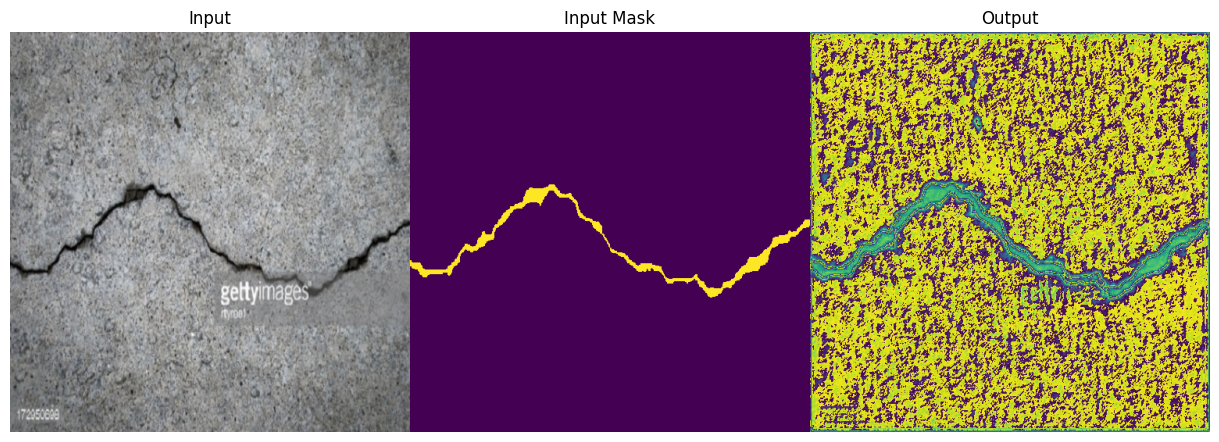

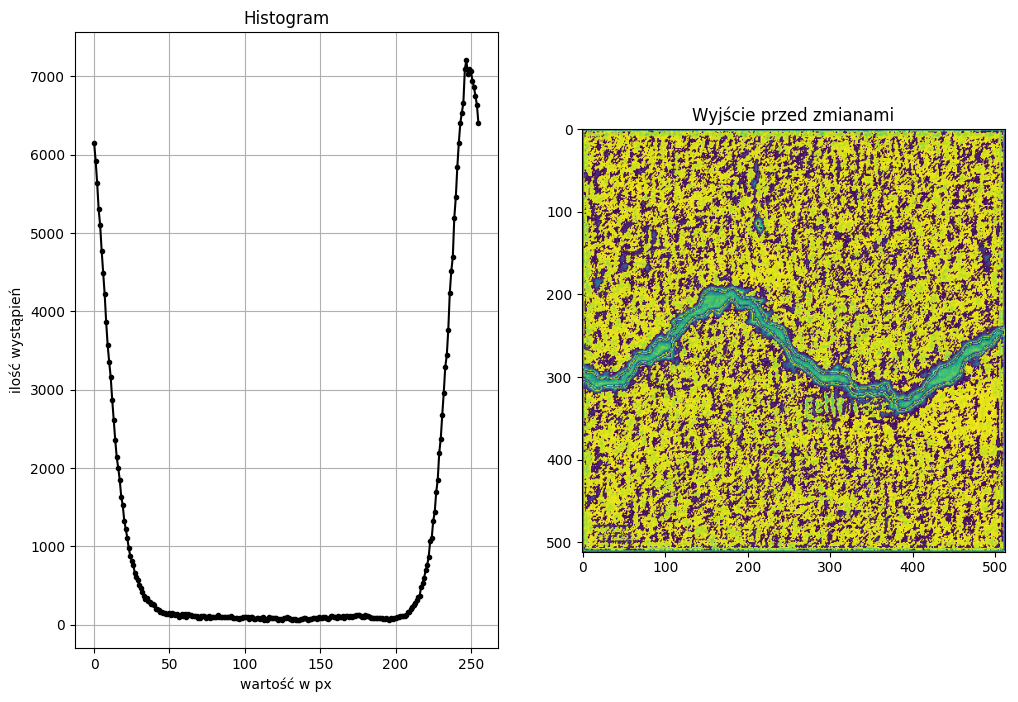

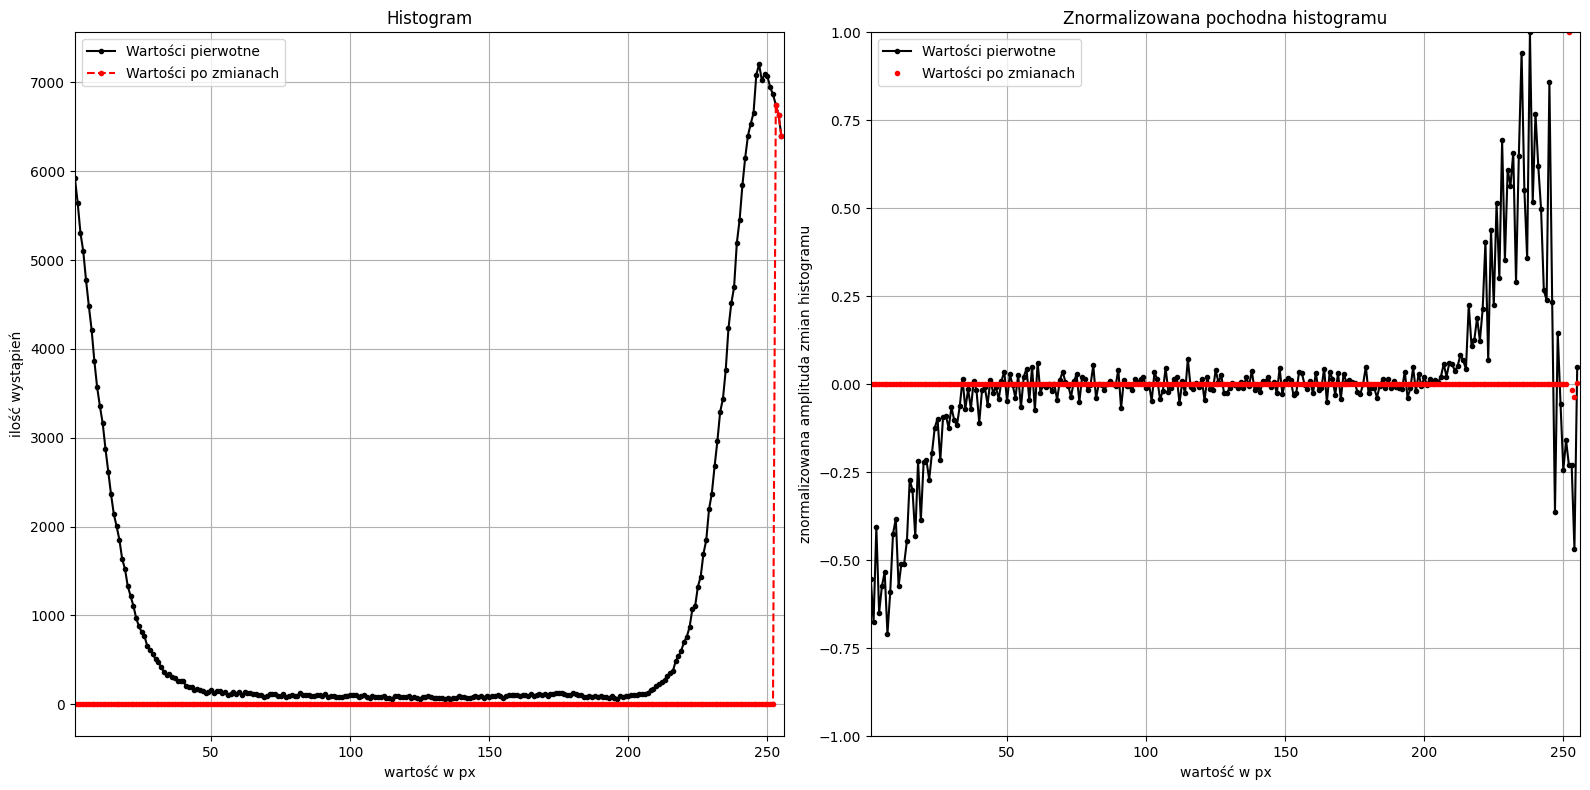

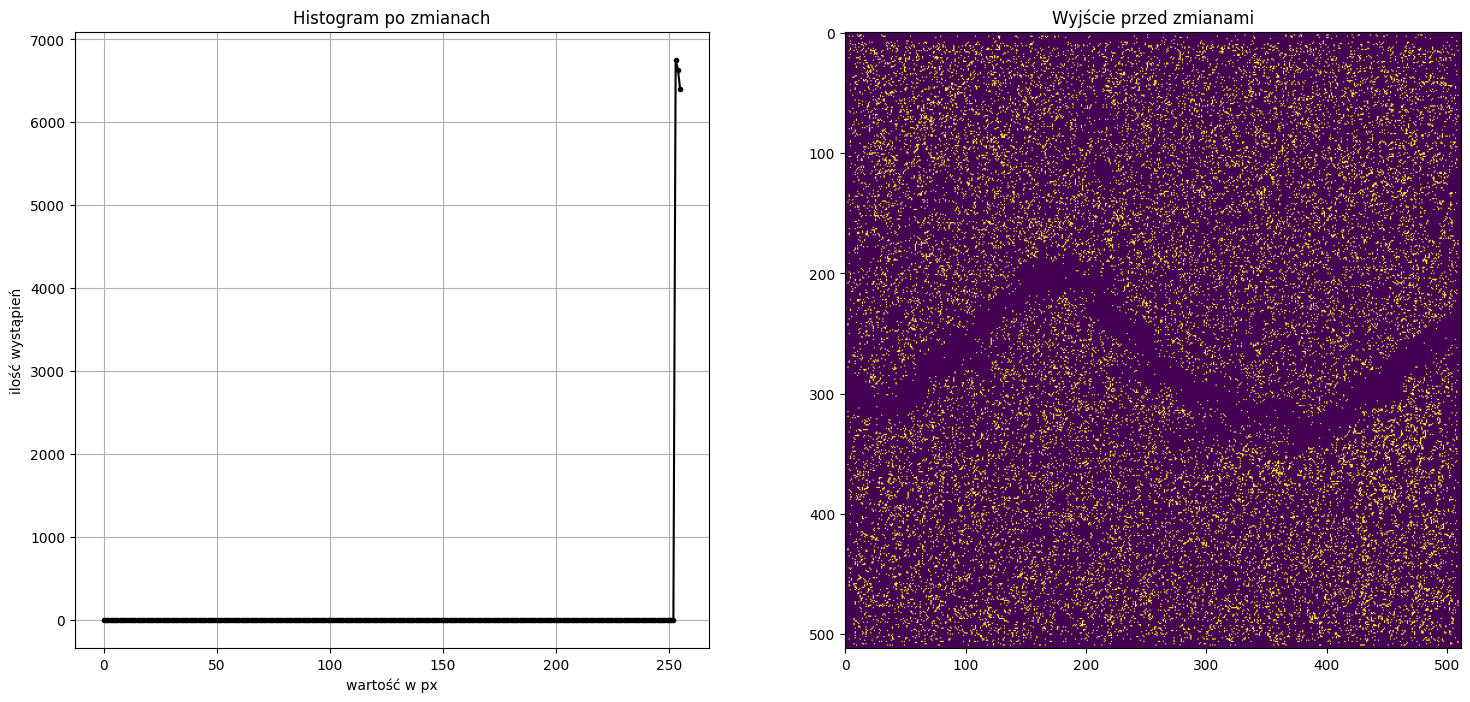

/tmp/ipykernel_26832/745603272.py:95: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  mask_removed_holes = remove_small_holes(mask_closed, area_threshold=min_hole, connectivity=connectivity)


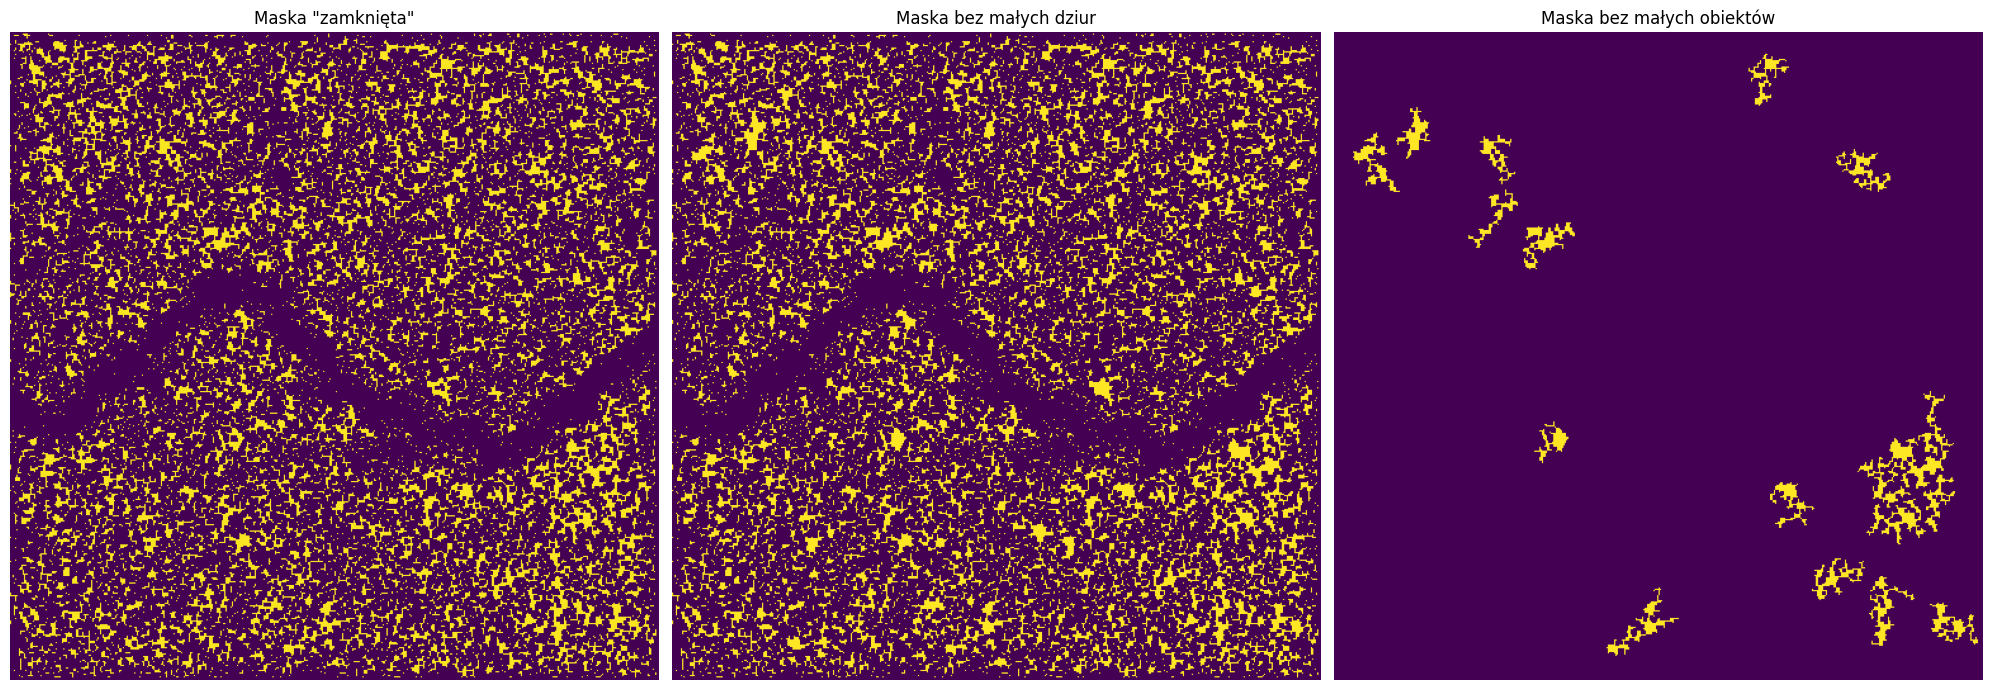

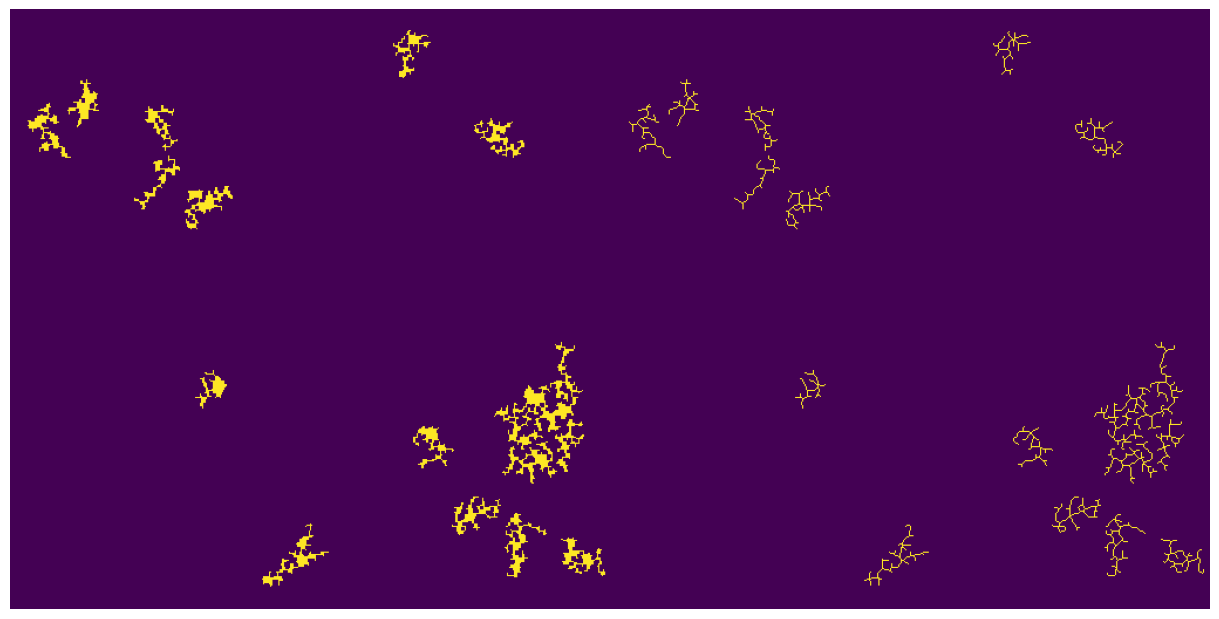

area,126.0 
area_convex,750.0 
equivalent_diameter_area,12.666024736934256 
extent,0.10641891891891891 
feret_diameter_max,39.96248240537617 
perimeter_crofton,239.87737225114066 
area,109.0 
area_convex,656.0 
equivalent_diameter_area,11.780624362746345 
extent,0.10480769230769231 
feret_diameter_max,40.792156108742276 
perimeter_crofton,200.44001449452077 
area,132.0 
area_convex,956.0 
equivalent_diameter_area,12.964089628857149 
extent,0.07971014492753623 
feret_diameter_max,49.39635614091387 
perimeter_crofton,250.373402700351 
area,122.0 
area_convex,725.0 
equivalent_diameter_area,12.463355264843006 
extent,0.11466165413533834 
feret_diameter_max,40.496913462633174 
perimeter_crofton,226.98567906563937 
area,158.0 
area_convex,940.0 
equivalent_diameter_area,14.183506197980657 
extent,0.1133428981348637 
feret_diameter_max,45.79301256742124 
perimeter_crofton,294.4442129451582 
area,95.0 
area_convex,722.0 
equivalent_diameter_area,10.998079684646791 
extent,0.052954292084726864

In [59]:
i,m =  dataset[10]

np_i = ten2np(i)
np_m = ten2np(m)

i = i.unsqueeze(0)

out = model(i)
np_out = ten2np(out)

# np_out = np.abs(255 - np_out)

print(np_out)

fig, ax = plt.subplots(1,3, figsize=(12, 8))
ax[0].imshow(np_i)
ax[0].set_title("Input")
ax[1].imshow(np_m)
ax[1].set_title("Input Mask")
ax[2].imshow(np_out)
ax[2].set_title("Output")
for a in ax:
  a.axis("off")


plt.tight_layout(pad=0)
plt.show()
model_postprocess(np_out,threshold=.12,connectivity=10, min_hole=250, undersampling=12, plot=True)


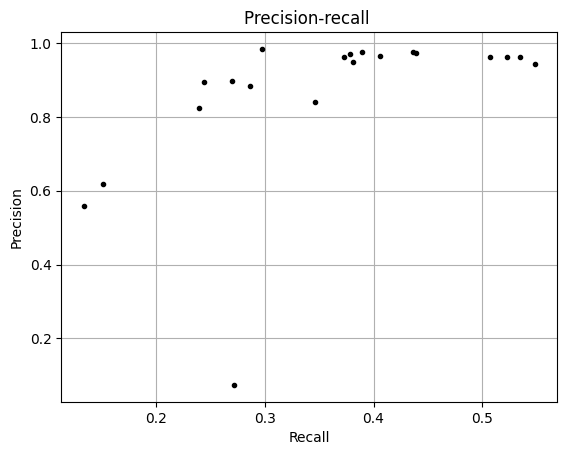

In [50]:

# vals for just focal
recall = [0.272300958633423,0.134069725871086,0.151613116264343,0.244582429528236,0.27003139257431,0.346601754426956,0.239937573671341,0.297753572463989,0.373323291540146,0.287043869495392,0.377992570400238,0.380733758211136,0.389227598905563,0.439085721969605,0.548007726669312,0.436596810817719,0.405770599842072,0.507129669189453,0.522498548030853,0.534625172615051,]
precision = [0.0741183087229729,0.559875905513763,0.616961121559143,0.893858909606934,0.897372007369995,0.839668035507202,0.822751343250275,0.98386424779892,0.962635159492493,0.882254660129547,0.969668745994568,0.949803233146668,0.976527214050293,0.973014891147614,0.942899763584137,0.976658880710602,0.965237438678742,0.961475312709808,0.961027383804321,0.961284875869751,]

x = np.linspace(0,1,10)

plt.plot(recall, precision, ".k")
# plt.plot(x,x,"r--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-recall ")
plt.grid()
plt.show()


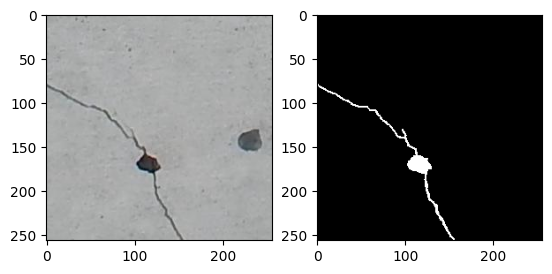

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [65]:
img_path = "/home/krzeslaav/colab_sync/DeepCrack/test_img/crack-o-680.jpg" 
mask_path = "/home/krzeslaav/colab_sync/DeepCrack/test_lab/crack-o-680.png"

nimg = np.asarray(Image.open(img_path))
nmsk = np.asarray(Image.open(mask_path))

fig, ax = plt.subplots(1,2)
ax[0].imshow(nimg)
ax[1].imshow(nmsk, cmap="gray")
plt.show()

mask_min = np.sum(nmsk)
print(nmsk)


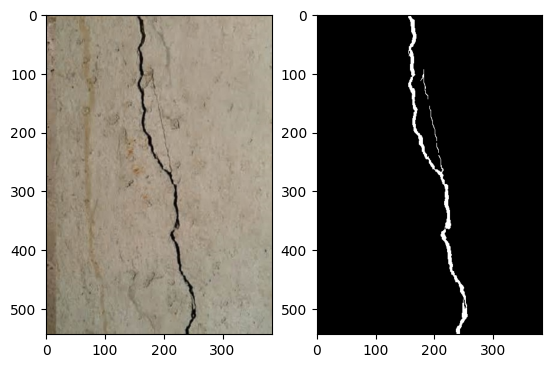

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [66]:
img_path = "/home/krzeslaav/colab_sync/DeepCrack/test_img/11304.jpg" 
mask_path = "/home/krzeslaav/colab_sync/DeepCrack/test_lab/11304.png"

nimg = np.asarray(Image.open(img_path))
nmsk = np.asarray(Image.open(mask_path))

fig, ax = plt.subplots(1,2)
ax[0].imshow(nimg)
ax[1].imshow(nmsk, cmap="gray")
plt.show()

mask_min = np.sum(nmsk)
print(nmsk)

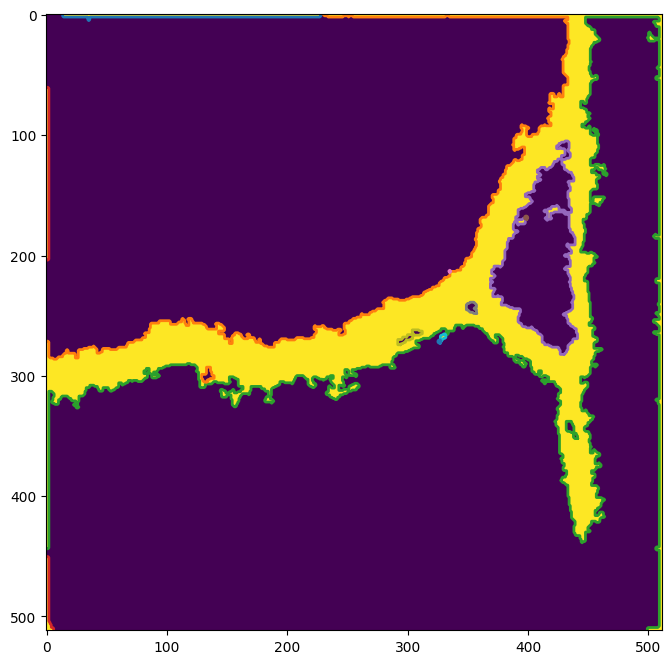

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))
# contours = find_contours(mask_removed_objects, .2)
# ax.imshow(mask_removed_objects)


# for n, contour in enumerate(contours):
#   ax.plot(contour[:,1], contour[:,0], linewidth=2)
# # plt.imshow(np_out)
# plt.show()
